In [1]:
#Importing Libraries

import rasterio
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import glob
import geopandas as gpd
from rasterio.features import shapes
from rasterio.mask import mask
import gdal
import osgeo
from shapely.geometry import box
from shapely.geometry import Polygon
import geopandas as gpd
from rasterio.mask import mask
import fiona

### Pre data

In [2]:
#Composite of images 


def composite_band(input_dir, output_dir):
    path=input_dir
    print(' >>> Composite image generation .... ')
    parent_dir = path.split(path.split(os.sep)[-5])[0]
    #filename
    filename_b4 = glob.glob(os.path.join(input_dir,"*B4.tif"))[0]
    filename_b3 = glob.glob(os.path.join(input_dir,"*B3.tif"))[0]
    filename_b2 = glob.glob(os.path.join(input_dir,"*B2.tif"))[0]
   
#     filename_b4 = glob.glob(os.path.join(input_dir,"*B04.jp2"))[0]
#     filename_b3 = glob.glob(os.path.join(input_dir,"*B03.jp2"))[0]
#     filename_b2 = glob.glob(os.path.join(input_dir,"*B02.jp2"))[0]
   
    bnd_4 = rasterio.open(filename_b4)
    b4 = bnd_4.read(1)
    bnd_3 = rasterio.open(filename_b3)
    b3 = bnd_3.read(1)
    bnd_2 = rasterio.open(filename_b2)
    b2 = bnd_2.read(1)

    band_geo = bnd_4.profile
    band_geo.update({"count": 3})
    
    comp_path = os.path.join(output_dir, path.split(os.sep)[-2]+'_rgb.tiff')
    with rasterio.open(comp_path, 'w', **band_geo) as dest:
    # I rearanged the band order writting to 2→3→4 instead of 4→3→2
        dest.write(bnd_4.read(1),1)
        dest.write(bnd_3.read(1),2)
        dest.write(bnd_2.read(1),3)

    return comp_path

In [3]:
#Composite Image

input_dir = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\pre"
output_dir = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res"

composite_band(input_dir, output_dir)

 >>> Composite image generation .... 


'C:\\Deepali_pro\\Covid_19_impact\\Wildfire_california\\landsat\\res\\landsat_rgb.tiff'

### Post data

In [3]:
#Composite Image
input_dir = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\post"
output_dir = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\post"

composite_band(input_dir, output_dir)


 >>> Composite image generation .... 


'C:\\Deepali_pro\\Covid_19_impact\\Wildfire_california\\landsat\\res\\post\\landsatrgb.tiff'

In [4]:
#converting clip into shape file
"""Function for converting image to boundary extent polygon""" 
def img_to_poly(path, filename):   
    src1 = gdal.Open(path)
    #boundary points
    ulx1, xres1, xskew1, uly1, yskew1, yres1  = src1.GetGeoTransform()
    lrx1 = ulx1 + (src1.RasterXSize * xres1)
    lry1 = uly1 + (src1.RasterYSize * yres1)
    source = osgeo.osr.SpatialReference()
    source.ImportFromWkt(src1.GetProjection())
    ##Creating a Polygon of image with Box of Shapely
    minx2 = lrx1
    miny2 = lry1
    maxx2 = ulx1
    maxy2 = uly1
    polygon2 = box(minx2,miny2,maxx2,maxy2)
    #converting that polygon into shapefile
    polygon_geom = polygon2
    img=rasterio.open(path)
    band2_geo = img.meta
    projectionId=str(band2_geo["crs"]).split(":")[-1]
    crs = {'init': 'epsg:'+projectionId}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
    #filename for shapefile
    filename = filename
    polygon.to_file(filename=filename, driver="ESRI Shapefile")
    return filename

In [5]:
#clip-1
path_1 = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\AOI\aoi.tif"
filename_1 = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\AOI\aoi.shp"

img_to_poly(path_1, filename_1)

c:\users\dell\.conda\envs\sar\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


'C:\\Deepali_pro\\Covid_19_impact\\Wildfire_california\\landsat\\AOI\\aoi.shp'

In [6]:
"""Image clipping function"""
def clip_img(shapefile, Parent_img_path, clip_img_path):
    # Read Shape file
    with fiona.open(shapefile, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]   
    # read imagery file
    with rasterio.open(Parent_img_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    # Save clipped imagery
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    with rasterio.open(clip_img_path, "w", **out_meta) as dest:
        dest.write(out_image)        
    return clip_img_path

In [21]:
#clip images according to clip-1

# composite-pre clip
shapefile = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\AOI\aoi.shp"
img_path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\pre\landsatrgb_pre.tiff"
clip_img_path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\pre\landsatrgb_pre_clip.tiff"
clip_img(shapefile, img_path, clip_img_path)
#composite-post clip
shapefile = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\AOI\aoi.shp"
img_path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\post\landsatrgb_post.tiff"
clip_img_path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\post\landsatrgb_post_clip.tiff"
clip_img(shapefile, img_path, clip_img_path)
#nir-pre clip
img_path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\pre\LC08_L2SP_045032_20200715_20200912_02_T1_SR_B5.TIF"
clip_img_path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\pre\landsat_nir_pre_clip.tiff"
clip_img(shapefile, img_path, clip_img_path)
#swir pre clip
img_path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\pre\LC08_L2SP_045032_20200715_20200912_02_T1_SR_B7.TIF"
clip_img_path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\pre\landsat_swir_pre_clip.tiff"
clip_img(shapefile, img_path, clip_img_path)
#nir post clip
img_path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\post\LC08_L2SP_045032_20200917_20201005_02_T1_SR_B5.TIF"
clip_img_path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\post\landsat_nir_post_clip.tiff"
clip_img(shapefile, img_path, clip_img_path)
#swir post clip
img_path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\post\LC08_L2SP_045032_20200917_20201005_02_T1_SR_B7.TIF"
clip_img_path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\post\landsat_swir_post_clip.tiff"
clip_img(shapefile, img_path, clip_img_path)

'C:\\Deepali_pro\\Covid_19_impact\\Wildfire_california\\landsat\\res\\post\\landsat_swir_post_clip.tiff'

### NBR :
Normalized burn ratio (NBR) is the index that is used to measure burn severity by distinguishing areas that have been significantly altered in their spectral signature after a wildfire event. It is calculated using the energy intensity from the NIR and SWIR wavelength bands from the remotely sensed satellite imagery. The formula for NBR is similar to the Normalized Difference Vegetation Index (NDVI), which is based on the intensity of light coming from NIR and red wavelength bands. NBR uses the ratio between NIR and SWIR bands. High NBR values reflect areas covered with healthy vegetation, whereas low values indicate bare ground and recently burned areas. Near-zero values represent areas that are not affected by the fire event.


In [35]:
# pre
nir_pre = rasterio.open(r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\pre\landsat_nir_pre_clip.tiff")
nir_pre_data = nir_pre.read(1)
swir_pre = rasterio.open(r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\pre\landsat_swir_pre_clip.tiff")
swir_pre_data = swir_pre.read(1)
# NBR 
NBR_pre = (nir_pre_data.astype('float32') - swir_pre_data.astype('float32'))/(nir_pre_data.astype('float32') + swir_pre_data.astype('float32'))

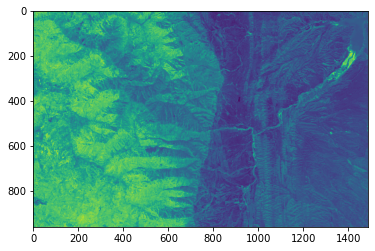

In [36]:
plt.imshow(NBR_pre)

In [37]:
NBR_pre.shape

(961, 1489)

In [39]:
# save image
band_geo = nir_pre.meta

band_geo.update({"count": 1})
band_geo.update({"dtype": 'float32'})
band_geo.update({'driver':'GTiff'})

path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\pre\nbr_pre.tif"
with rasterio.open(path, 'w', **band_geo) as dest:
    dest.write(NBR_pre,1)

In [31]:
# post
nir_post = rasterio.open(r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\post\landsat_nir_post_clip.tiff")
nir_post_data = nir_post.read(1)
swir_post = rasterio.open(r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\post\landsat_swir_post_clip.tiff")
swir_post_data = swir_post.read(1)
# NBR 
NBR_post = (nir_post_data.astype('float32') - swir_post_data.astype('float32'))/(nir_post_data.astype('float32') + swir_post_data.astype('float32'))

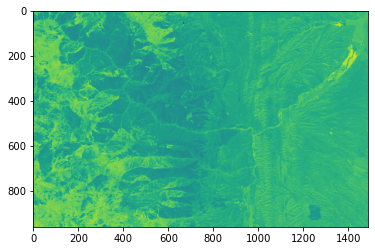

In [32]:
plt.imshow(NBR_post)

In [33]:
nir_post_data.dtype

dtype('uint16')

In [34]:
# save image
band_geo = nir_post.meta

band_geo.update({"count": 1})
band_geo.update({"dtype": 'float32'})
band_geo.update({'driver':'GTiff'})

path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\post\nbr_post.tif"
with rasterio.open(path, 'w', **band_geo) as dest:
    dest.write(NBR_post,1)

### Burn severity:
is a term used to represent the degree to which an ecosystem is impacted by a wildfire event. It is estimated as the difference between pre-fire and post-fire NBR derived from satellite images. To identify recently burned areas and differentiate them from bare soil and other non-vegetated areas, the difference between pre-fire and post-fire NBR, also known as the delta normalized burn ratio (dNBR) index is frequently used. Areas with high dNBR value correspond to a higher degree of damage or burn severity. In contrast, low dNBR values represent areas that are unaffected from the fire event or regions that have rebounded via regrowth of plant species following a wildfire incident.

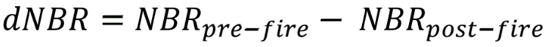



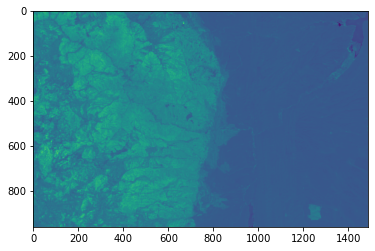

In [40]:
#dNBR 

dNBR = NBR_pre - NBR_post
plt.imshow(dNBR)

In [41]:
# save image
band_geo = nir_post.meta

band_geo.update({"count": 1})
band_geo.update({"dtype": 'float32'})
band_geo.update({'driver':'GTiff'})

path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\DNBR.tif"
with rasterio.open(path, 'w', **band_geo) as dest:
    dest.write(dNBR,1)

### Identify Burned Areas

At this point, we should have two NBR bands each corresponding to the pre-fire and post-fire date. To identify recently burned areas, dNBR can be calculated by differencing the post-fire NBR from the pre-fire NBR. However, dNBR is an absolute measure of change, which can lead to issues in areas with low pre-fire vegetation cover, where the difference will be insignificant. To avoid such problems, we use the relativized burn ratio (RBR):

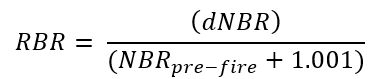
RBR is calculated by making a small adjustment to the pre-fire NBR in order to avoid the equation to ever reaching infinity and fail. Once RBR has been calculated, we can use BandMaths tool to identify recently burned areas by creating a new band that will only contain pixels that have RBR values above a specified threshold. We can visualize the change in RBR values, which as we have established is the measure used for burn area assessment

In [42]:
#RBR

RBR = (dNBR)/(NBR_pre + 1.001)


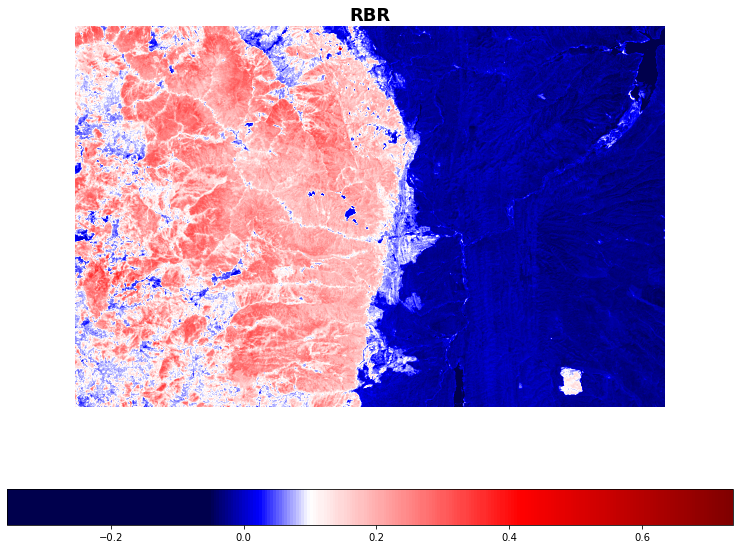

In [55]:
# cmaps['Diverging'] = [
#             'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
#             'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

class MidpointNormalize(colors.Normalize):
        """
        Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
        e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
        Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
        """
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            # I'm ignoring masked values and all kinds of edge cases to make a
            # simple example...
            x, y = [self.vmin, self.midpoint, self.vmax], [-1, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

min=np.nanmin(RBR)
max=np.nanmax(RBR)
# print('min',min,'max',max)
mid=0.1
norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cmap = plt.cm.seismic 
cax = ax.imshow(RBR, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))
ax.axis('off')
ax.set_title('RBR', fontsize=18, fontweight='bold')
cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)
fig.savefig(r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\RBR.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

In [54]:
# save image
band_geo = nir_post.meta

band_geo.update({"count": 1})
band_geo.update({"dtype": 'float32'})
band_geo.update({'driver':'GTiff'})

path = r"C:\Deepali_pro\Covid_19_impact\Wildfire_california\landsat\res\RBR.tif"
with rasterio.open(path, 'w', **band_geo) as dest:
    dest.write(RBR,1)